In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

csv_path = './Resource_Management_Process.csv'
df = pd.read_csv(csv_path)

###DoW의 값을 숫자로 매핑
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

dowReplace_df = df
# DoW 열의 값을 변경
dowReplace_df['DoW'] = dowReplace_df['DoW'].map(day_mapping)

In [26]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 다중공산성을 분석할 데이터프레임 df가 있다고 가정합니다.

# 독립 변수들만을 선택하여 새로운 데이터프레임 X를 생성합니다.
X = dowReplace_df[['Production', 'Temperature', 'Humidity', 'Power_Cost', 'Worker_Power','DoW']]

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# 결과 출력
print(vif_data)

        feature        VIF
0    Production   5.839705
1   Temperature   6.938597
2      Humidity  11.060260
3    Power_Cost  22.717491
4  Worker_Power   3.367256
5           DoW   3.206448


In [27]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 랜덤 포레스트 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 데이터 준비 (X: 독립 변수, y: 종속 변수)
X = dowReplace_df[['Production', 'Temperature', 'Humidity', 'Power_Cost', 'Worker_Power','DoW']]
y = dowReplace_df['Power_Usage']

# 모델 피팅
rf_model.fit(X, y)

# 변수 중요도 출력
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("변수 중요도:")
for i, feature in enumerate(X.columns[indices]):
    print(f"{i + 1}. {feature}: {importances[indices[i]]}")

변수 중요도:
1. Production: 0.5877016475731119
2. Worker_Power: 0.15071718783743487
3. Temperature: 0.09779886290699552
4. Humidity: 0.07569121221459973
5. DoW: 0.05217658966476343
6. Power_Cost: 0.03591449980309435


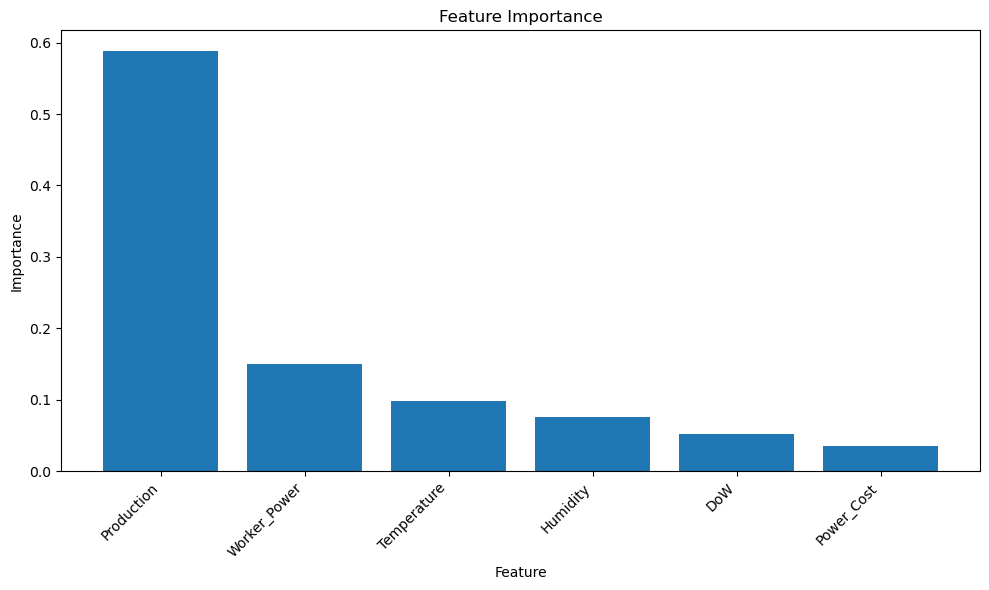

In [28]:
import matplotlib.pyplot as plt

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), X.columns[indices], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [29]:
dropped_df = dowReplace_df.drop(columns=['Power_Cost'])
dropped_df

,Datetime,Production,Temperature,Humidity,DoW,Worker_Power,Man_Cost,Power_Usage
0,2021-02-08 0:15,116,-4.2,65.6,0,0.13,1.5,103
1,2021-02-08 0:30,116,-4.2,63.5,0,0.13,1.5,100
2,2021-02-08 0:45,114,-4.2,67.6,0,0.14,1.5,109
3,2021-02-08 1:00,114,-5.5,72.8,0,0.13,1.5,161
4,2021-02-08 1:15,116,-5.5,67.4,0,0.15,1.5,136
...,...,...,...,...,...,...,...,...
24474,2021-10-21 22:45,129,23.6,74.0,3,0.30,1.5,162
24475,2021-10-21 23:00,217,22.5,74.6,3,1.07,1.5,134
24476,2021-10-21 23:15,217,22.2,71.3,3,1.05,1.5,157
24477,2021-10-21 23:30,213,23.1,72.7,3,1.05,1.5,163


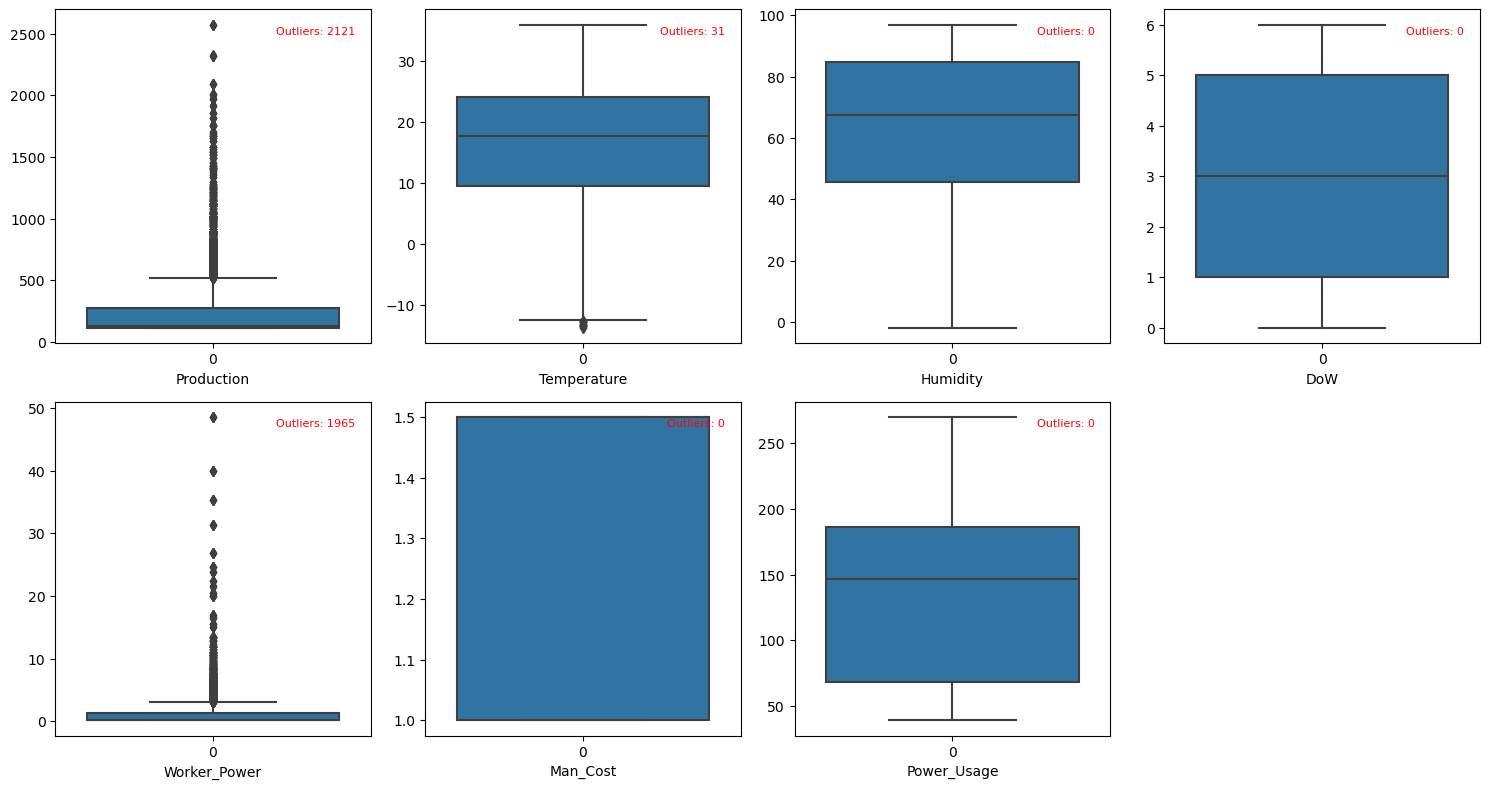

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# 이상치를 식별하여 개수와 함께 출력하는 함수
def detect_and_count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers.index, len(outliers)
    
# 숫자형 데이터만 선택
numeric_columns = dropped_df.select_dtypes(include=[np.number])

# 박스 플롯을 4개씩 한 행에 배치하여 출력
num_plots = len(numeric_columns.columns)
num_rows = (num_plots - 1) // 4 + 1

fig, axes = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))

for i, column in enumerate(numeric_columns.columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    sns.boxplot(data=dropped_df[column], ax=ax)
    ax.set_xlabel(column)

    # 이상치 개수 계산
    outliers_index, outliers_count = detect_and_count_outliers(dropped_df, column)
    ax.text(0.95, 0.95, f"Outliers: {outliers_count}", verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, color='red', fontsize=8)

# 마지막으로 그리드의 빈 플롯을 숨기기
for i in range(num_plots, num_rows * 4):
    row = i // 4
    col = i % 4
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


In [31]:
temperature_outliers, temperature_outliers_count = detect_and_count_outliers(dropped_df, 'Temperature')
Production_outliers, Production_outliers_count = detect_and_count_outliers(dropped_df, 'Production')
Worker_Power_outliers, Worker_Power_outliers_count = detect_and_count_outliers(dropped_df, 'Worker_Power')
#이상치 개수
print("Temperature 이상치의 개수:", temperature_outliers_count)
print("Production 이상치의 개수:", Production_outliers_count)
print("Worker_Power 이상치의 개수:", Worker_Power_outliers_count)
#이상치의 행
print("Temperature 이상치의 행 index:", temperature_outliers)
print("Production 이상치의 행 index:", Production_outliers)
print("Worker_Power 이상치의 행 index:", Worker_Power_outliers)

Temperature 이상치의 개수: 31
Production 이상치의 개수: 2121
Worker_Power 이상치의 개수: 1965
Temperature 이상치의 행 index: Index([669, 673, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686,
       690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703,
       704, 705, 706],
      dtype='int64')
Production 이상치의 행 index: Index([  327,   328,   329,   330,   343,   344,   345,   346,   347,   348,
       ...
       24421, 24422, 24427, 24428, 24429, 24430, 24431, 24432, 24433, 24434],
      dtype='int64', length=2121)
Worker_Power 이상치의 행 index: Index([  327,   328,   329,   330,   343,   344,   345,   346,   347,   348,
       ...
       24365, 24366, 24427, 24428, 24429, 24430, 24431, 24432, 24433, 24434],
      dtype='int64', length=1965)


In [14]:
from collections import Counter

# 이상치의 행 index 모으기
all_outliers = np.concatenate([temperature_outliers, Production_outliers, Power_Cost_outliers, Worker_Power_outliers])
# all_outliers = np.concatenate([temperature_outliers, Production_outliers, Worker_Power_outliers])
# 각 행의 등장 횟수 세기
outliers_counter = Counter(all_outliers)

# Temperature 열의 이상치가 2번 이상 겹치는 행과 그 횟수 추출
common_outliers = {index: count for index, count in outliers_counter.items() if count >= 2 and index in temperature_outliers}

# 행 번호를 리스트에 담기
common_outliers_list = list(common_outliers.keys())

print("Temperature 열의 이상치가 2번 이상 겹치는 이상치의 행 번호와 횟수:")
for index, count in common_outliers.items():
    print(f"행 번호: {index}, 횟수: {count}")

# 행 번호 리스트 출력
print("행 번호 리스트:", common_outliers_list)

Temperature 열의 이상치가 2번 이상 겹치는 이상치의 행 번호와 횟수:
행 번호: 669, 횟수: 2
행 번호: 673, 횟수: 2
행 번호: 675, 횟수: 2
행 번호: 676, 횟수: 2
행 번호: 677, 횟수: 2
행 번호: 678, 횟수: 2
행 번호: 679, 횟수: 2
행 번호: 680, 횟수: 2
행 번호: 681, 횟수: 2
행 번호: 682, 횟수: 2
행 번호: 683, 횟수: 2
행 번호: 684, 횟수: 2
행 번호: 685, 횟수: 2
행 번호: 686, 횟수: 2
행 번호: 690, 횟수: 2
행 번호: 691, 횟수: 2
행 번호: 692, 횟수: 2
행 번호: 693, 횟수: 2
행 번호: 694, 횟수: 2
행 번호: 695, 횟수: 2
행 번호: 696, 횟수: 2
행 번호: 697, 횟수: 2
행 번호: 698, 횟수: 2
행 번호: 699, 횟수: 3
행 번호: 700, 횟수: 3
행 번호: 701, 횟수: 3
행 번호: 702, 횟수: 3
행 번호: 703, 횟수: 2
행 번호: 704, 횟수: 2
행 번호: 705, 횟수: 2
행 번호: 706, 횟수: 2
행 번호 리스트: [669, 673, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706]


In [32]:
# 이상치를 제거하기 위해 해당 행들의 인덱스를 사용하여 데이터프레임을 필터링
cleaned_df = dropped_df.drop(common_outliers_list)

# 이상치가 제거된 데이터프레임 출력
print(cleaned_df)

               Datetime  Production  Temperature  Humidity  DoW  Worker_Power  \
0       2021-02-08 0:15         116         -4.2      65.6    0          0.13   
1       2021-02-08 0:30         116         -4.2      63.5    0          0.13   
2       2021-02-08 0:45         114         -4.2      67.6    0          0.14   
3       2021-02-08 1:00         114         -5.5      72.8    0          0.13   
4       2021-02-08 1:15         116         -5.5      67.4    0          0.15   
...                 ...         ...          ...       ...  ...           ...   
24474  2021-10-21 22:45         129         23.6      74.0    3          0.30   
24475  2021-10-21 23:00         217         22.5      74.6    3          1.07   
24476  2021-10-21 23:15         217         22.2      71.3    3          1.05   
24477  2021-10-21 23:30         213         23.1      72.7    3          1.05   
24478  2021-10-21 23:45         215         22.2      71.6    3          1.06   

       Man_Cost  Power_Usag